In [5]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
import robot_lib

In [6]:
nu = [0.0, 1, 0]

In [7]:
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i>=n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.1): 
    n = 0
    p = [0.0, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    
    robot = robot_lib.make_robot(nu[0], nu[1], nu[2])
    x_trajectory, y_trajectory, best_err = run(robot, p)  # initial err
    
    while sum(dp) >= tol:
        for i in range(len(p)):
            robot = robot_lib.make_robot(nu[0], nu[1], nu[2])
            p[i] += dp[i]
            _, _, err = run(robot, p)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2*dp[i]  # reverse the search direction
                robot = robot_lib.make_robot(nu[0], nu[1], nu[2])
                _, _, err = run(robot, p)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9  # narrow the search range
            n += 1
        if n % 5 == 0:
            pass#print("best err {} | params {} | dparams {}".format(best_err, p, dp))
    
    return p, best_err


params, err = twiddle()
print("Final twiddle error = {}".format(err))

Final twiddle error = 6.48624842097e-16


[2.9331227688652466, 10.326589894591532, 0.49316041639454494]


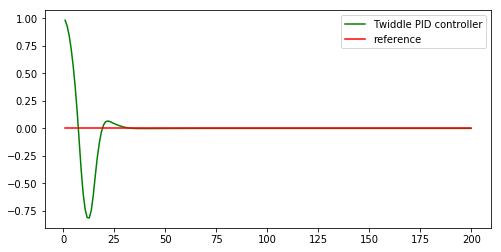

In [8]:
robot = robot_lib.make_robot(nu[0], nu[1], nu[2])
print (params)
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

In [10]:
def func_to_minimize(parameters):
    robot = robot_lib.make_robot(nu[0],nu[1],nu[2])
    return run(robot, parameters)[2]

 The best solution found:                                                                           
 [2.24094503 8.85473377 0.24882099]

 Objective function:
 5.704582005391103e-20


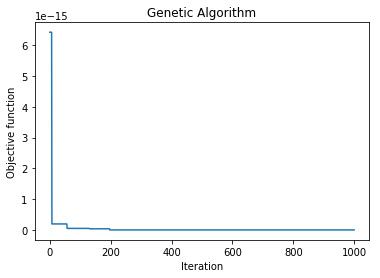

In [11]:
varbound=np.array([[0,10], [0,11], [-1,1]])
algorithm_param = {'max_num_iteration': 1000,\
                   'population_size':30,\
                   'mutation_probability':1.0,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.3,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
model=ga(function=func_to_minimize,dimension=3,variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param)
model.run()

[1.82542196 7.58535215 0.19519447]


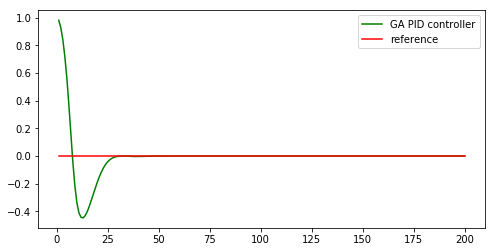

In [30]:
print (model.best_variable)
robot = robot_lib.make_robot(nu[0], nu[1], nu[2])
x_trajectory, y_trajectory, err = run(robot, model.best_variable)
n = len(x_trajectory)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='GA PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
#fig.savefig('Lib_GA_one')